In [2]:
import numpy as np
import h5py
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import skew, kurtosis
from itertools import combinations, combinations_with_replacement
import os
from importlib import reload

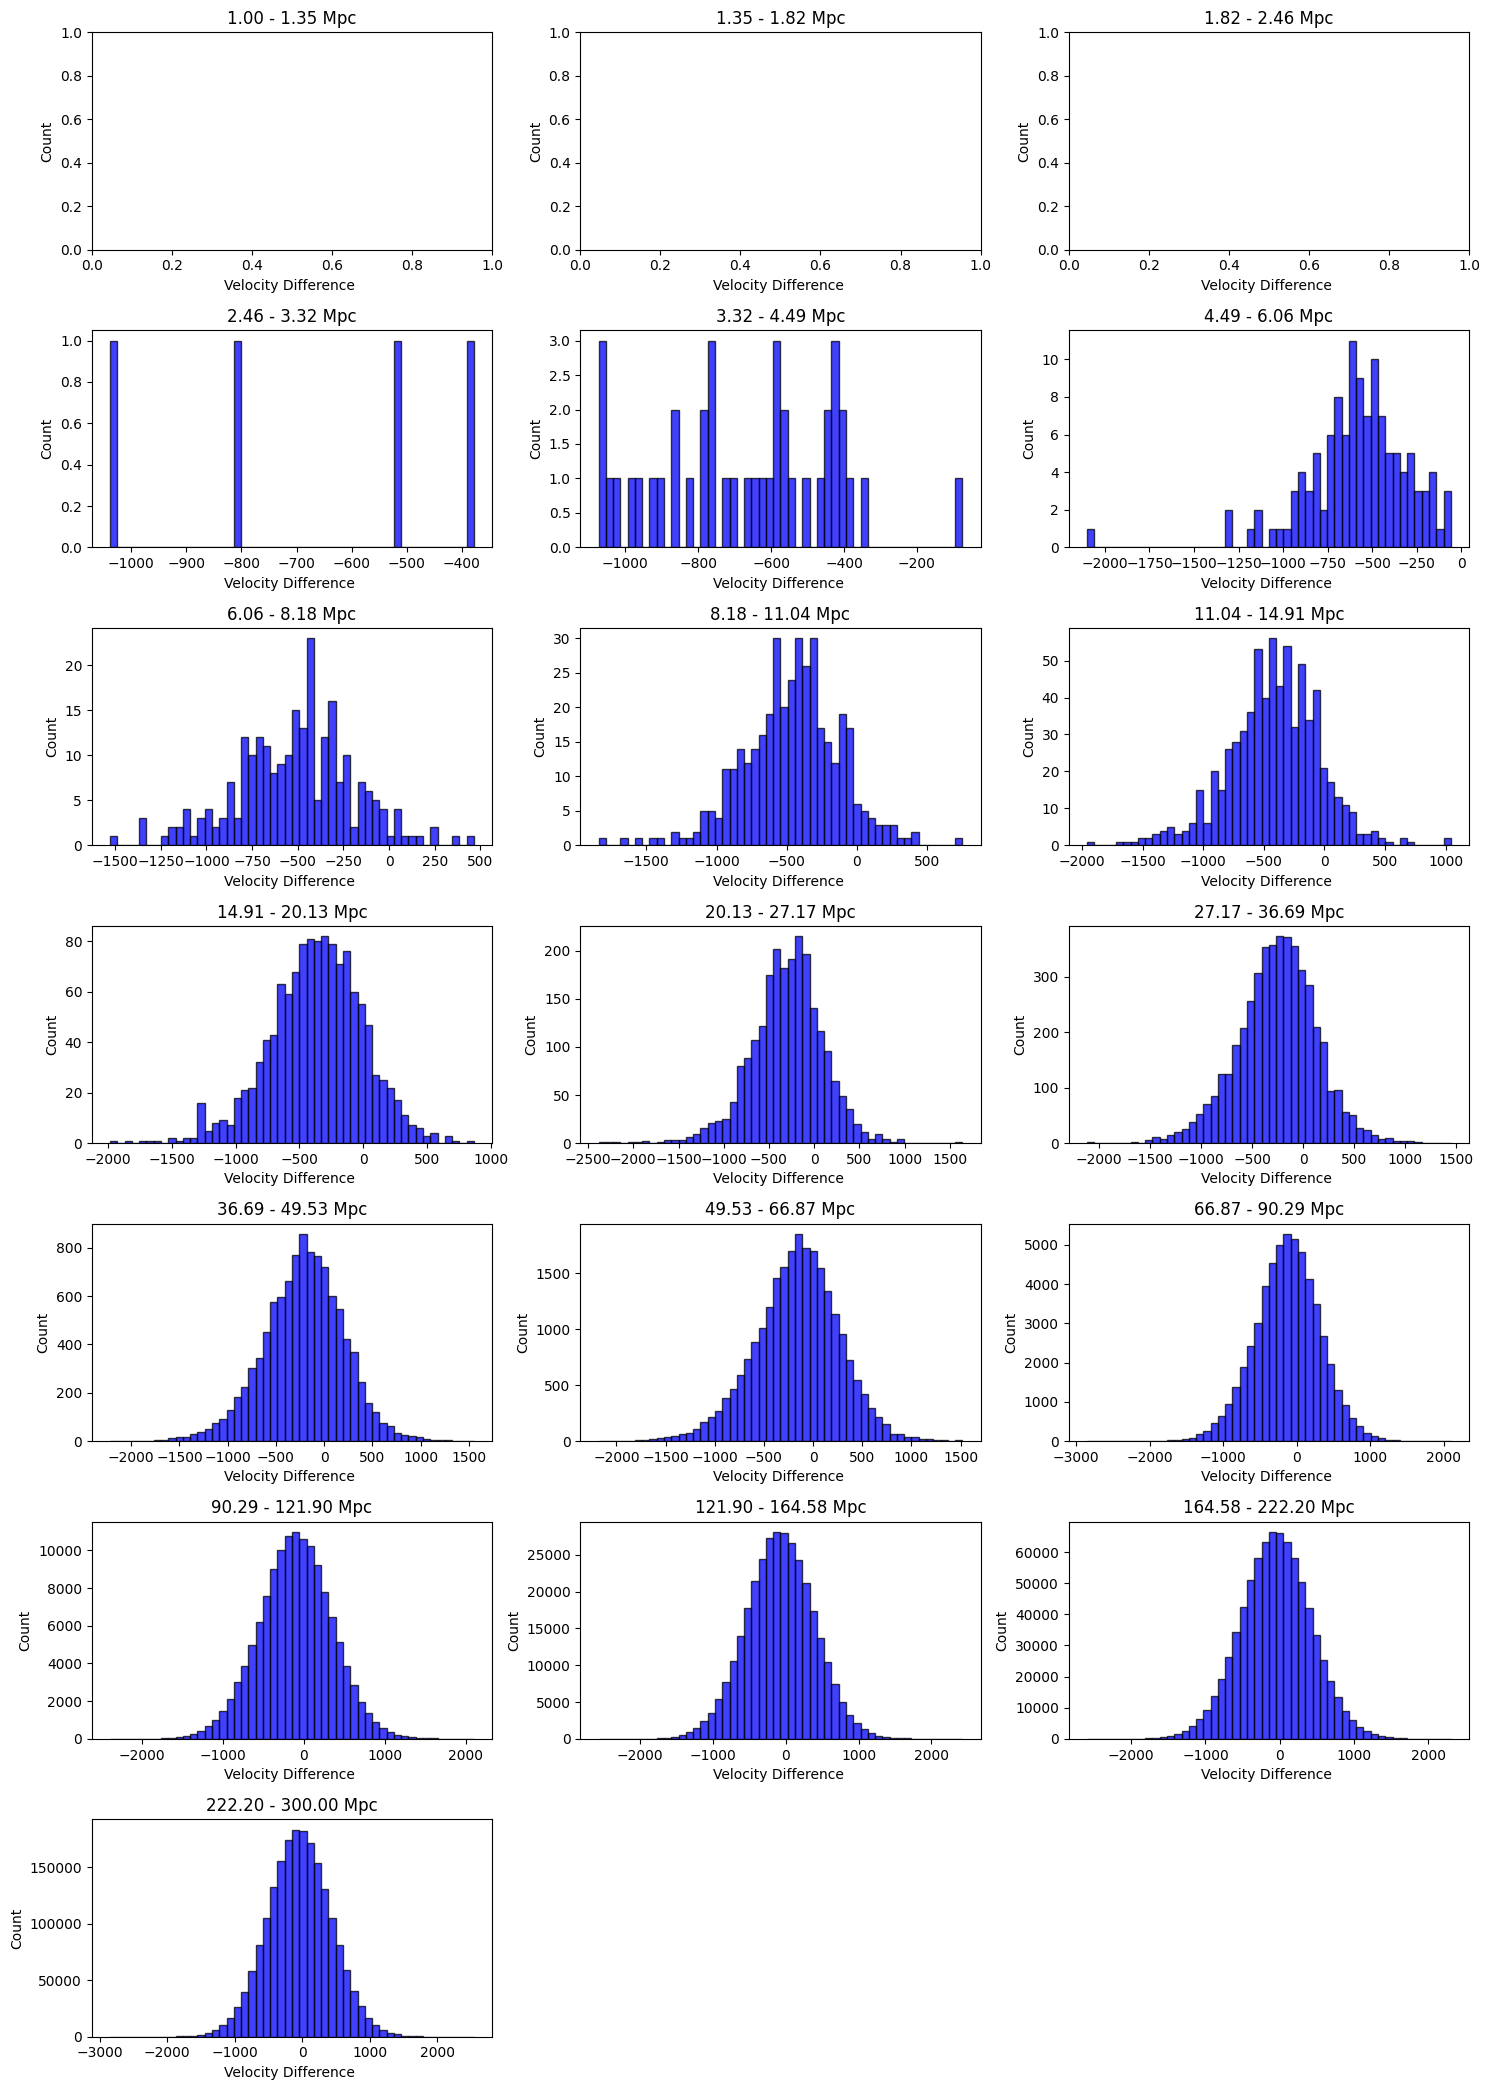

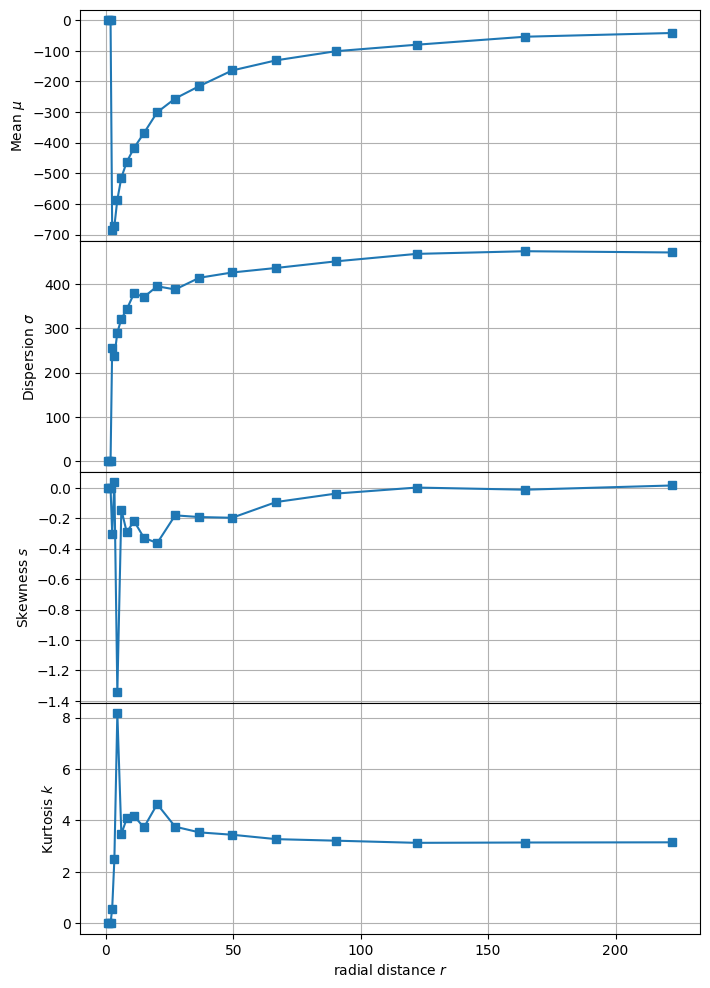

In [31]:
import plotting
reload(plotting)

plotter = plotting.Plotter('/disks/cosmodm/vdvuurst/data/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5')
plotter.plot_velocity_histograms(savefig=False, showfig=True)
plotter.plot_moments(savefig=False, showfig=True)

In [3]:
with h5py.File('/disks/cosmodm/vdvuurst/data/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5', 'r') as file:
    radii = file['radial_distances'][:]



In [21]:
nonzero = np.nonzero(radii)[0]
nonzero.shape

(25940262,)

In [3]:
np.floor(1.1)

np.float64(1.0)

In [55]:
np.logspace(0,np.log10(300),50)
np.log10(300) // 0.2 * 1e7

np.float64(120000000.0)

In [22]:
with h5py.File('/disks/cosmodm/vdvuurst/data/twohalotest_14-14.5_14.5-15.hdf5', 'r') as file:
    radii = file['radial_distances'][:]

radii.shape

(7274818,)

In [23]:
120000000 - 7274818

112725182

In [31]:
with h5py.File("/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5",'r') as file:
    COM = file["ExclusiveSphere/100kpc/CentreOfMass"][:]

COM

array([[ 23.73483533,  17.83004533,  24.04901533],
       [ 19.60605533,  21.42870533,  15.31533533],
       [  1.98542533,  14.54449533,  15.55260533],
       ...,
       [973.48526542, 981.18093542, 993.80764542],
       [979.06253542, 990.94543542, 969.53391542],
       [984.32196542, 986.70822542, 985.46498542]], shape=(15329653, 3))

In [32]:
mask = np.apply_along_axis(np.any, axis = 1, arr = COM >= 300)
mask.sum()

np.int64(14926342)

In [48]:
selection = COM >= 300
mask = np.sum(selection, axis = 1) == 0
print(mask)
mask.sum()

[ True  True  True ... False False False]


np.int64(403311)

In [66]:
def change(x,num):
    x = x[np.array(x) < 900]
    new =  np.random.choice(x,num, replace = False)
    x.resize((num,))
    x[:num] = new
    return x


with h5py.File('/disks/cosmodm/vdvuurst/data/test.hdf5','w') as f:
    dset_test = f.create_dataset('test',(100,),maxshape=(1000,), dtype = np.float32)

    dset_test.resize((1000,))
    dset_test[:1000] = np.arange(1000)

    num = 100
    dset_test[:num] = change(dset_test,num)
    dset_test[:num] = change(dset_test, num)
    dset_test.resize((num,))


with h5py.File('/disks/cosmodm/vdvuurst/data/test.hdf5','r') as f:
    test = f['test'][:]


test



array([396., 651., 668., 584., 108., 594., 169., 816., 431., 462., 869.,
       290., 519., 342., 296., 306., 725., 407., 686., 763., 175., 332.,
       237., 330., 598., 535., 496., 702., 480., 214., 738., 426., 489.,
       180., 424., 829., 680.,  31., 254., 554., 586., 485., 533., 312.,
       799., 346., 540., 474., 752., 364., 684., 225., 250., 491., 887.,
       376., 664., 707., 109., 168., 153., 150., 211., 328., 854., 473.,
       672., 852., 741., 890., 893., 871., 273., 387., 896., 544., 843.,
       596., 183., 631., 632., 663., 440., 751., 550., 461., 807., 895.,
       877., 181., 627., 665., 282., 864., 106., 826., 558., 834., 292.,
       196.], dtype=float32)

In [ ]:
totalmax = int(1e7)
wanted = int(1e5)
chance = wanted / totalmax

indices_to_choose = np.random.choice(np.arange(totalmax), wanted, replace = False)
print(indices_to_choose.shape)

with h5py.File('/disks/cosmodm/vdvuurst/data/test.hdf5', 'w') as f:
    dset_radial = f.create_dataset("radial_distances", (wanted,), maxshape=(wanted,), dtype=np.float32)
    counter = 0
    # for i in range(totalmax):
    #     if i not in indices_to_choose:
    #         continue
    for i in indices_to_choose:

        dset_radial[counter] = np.random.randint(low=1,high=100)
        counter += 1

    print(np.nonzero(dset_radial))


(100000,)
(array([    0,     1,     2, ..., 99997, 99998, 99999], shape=(100000,)),)


In [1]:
np.floor(1.1)

NameError: name 'np' is not defined

In [ ]:
pair_data_path = '/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5'
with h5py.File(pair_data_path,'r') as pair_data:
    radii = pair_data['radial_distances'][:]
    vels = pair_data['velocity_differences'][:]
    prim_masses = pair_data['primary_masses'][:]
    sec_masses = pair_data['secondary_masses'][:]
        
print('data loaded in')
type(sec_masses)

data loaded in


numpy.ndarray

In [138]:
test = np.arange(0,500,1)
radial_bins = np.logspace(0, np.log10(300), 20)
bin_idx =  np.digitize(test[test <= 300], radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin
bin_idx = bin_idx[bin_idx != -1]
unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)

# print(bin_idx)
# print(test[bin_idx])
radial_bin_counts.sum()

np.int64(300)

In [103]:
radial_bins = np.logspace(0, np.log10(300), 20)
bin_idx =  np.digitize(radii, radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin

unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)
radial_bin_counts[unique_bins == 3]

array([16])

In [ ]:
#NOTE this function is only for subsampling already existing data
def subsample_existing_data(pair_data_path, number_of_bins = 20, max_radius = 300, num_per_bin = int(1e7), overwrite = False):
    # num_per_bin is how many pairs we want to keep per radial bin
    # max_radius is the radial distance cut-off in Mpc

    with h5py.File(pair_data_path,'r') as pair_data:
        radii = pair_data['radial_distances'][:]
        vels = pair_data['velocity_differences'][:]
        prim_masses = pair_data['primary_masses'][:]
        sec_masses = pair_data['secondary_masses'][:]
    
    # Overwrite prim_masses by a new array which is now filled with prim masses to keep the same shape across
    #NOTE this is only relevant for old data so in the future this might become obsolete
    if prim_masses.shape != sec_masses.shape:
        sec_per_prim = sec_masses.shape[0] // prim_masses.shape[0] #we can use integer division because we are sure that this is in fact an integer
        prim_masses = np.array([np.full(sec_per_prim, prim_masses[i]) for i in range(prim_masses.shape[0])]).flatten()
    print('data loaded in')

    #First step is a simple maximum filter
    max_radius_mask = radii <= max_radius
    radii = radii[max_radius_mask]
    vels = vels[max_radius_mask]
    prim_masses = prim_masses[max_radius_mask]
    sec_masses = sec_masses[max_radius_mask]


    radial_bins = np.logspace(0, np.log10(max_radius), number_of_bins)
    bin_idx =  np.digitize(radii, radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin
    # print(radii[bin_idx == 19][:10])
    # bin_idx = bin_idx[(bin_idx != -1) & (bin_idx != number_of_bins - 1)]#this is the maximum radius filter; all values beyond the bounds are returned as 0 or len(radial_bins) = num_of_bins 
    
    unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)

    if overwrite:
        new_filepath = pair_data_path
    else:
        head, tail = os.path.split(pair_data_path)
        new_dir = os.path.join('/disks/cosmodm/vdvuurst/data', os.path.split(head)[1] + '_subsampled')
        if not os.path.isdir(new_dir):
            os.mkdir(new_dir)
        new_filepath = os.path.join(new_dir, tail) 

   # How many do we keep in the new dataset; we set a per radial bin ceiling
    dset_shape = radial_bin_counts[radial_bin_counts <= num_per_bin].sum() +\
                 radial_bin_counts[radial_bin_counts > num_per_bin].shape[0] * num_per_bin
    
    with h5py.File(new_filepath,'w') as f:
        dset_radial = f.create_dataset("radial_distances", (dset_shape,), dtype=np.float32)
        dset_velocities = f.create_dataset("velocity_differences", (dset_shape,), dtype=np.float32)
        dset_sec_masses = f.create_dataset("secondary_masses", (dset_shape,), dtype=np.float32)
        dset_prim_masses = f.create_dataset("primary_masses", (dset_shape,), dtype=np.float32)

        write_pointer = 0
        # for i,(bin,bin_count) in enumerate(zip(radial_bins,radial_bin_counts)):
        for i in range(number_of_bins):
            if i not in unique_bins: #i.e. there are no halo pairs in this radial bin
                continue

            bin_count = radial_bin_counts[unique_bins == i][0] #some low radius bins may not have any pairs so this is correct indexing
            if bin_count <= num_per_bin: 
                bin_mask = (bin_idx == i)
                dset_radial[write_pointer:write_pointer + bin_count] = radii[bin_mask]
                dset_velocities[write_pointer:write_pointer + bin_count] = vels[bin_mask]
                dset_sec_masses[write_pointer:write_pointer + bin_count] = sec_masses[bin_mask]
                dset_prim_masses[write_pointer:write_pointer + bin_count] = prim_masses[bin_mask]

                write_pointer += bin_count
                continue
            
            #if the above catches aren't activated we have to subsample
            bin_mask = bin_idx == i
            radii_in_bin = radii[bin_mask]
            velocities_in_bin = vels[bin_mask]
            sec_masses_in_bin = sec_masses[bin_mask]
            prim_masses_in_bin = prim_masses[bin_mask]

            # WE LOSE ORDERING! is this bad? not if we lose the ordering in the same way across the dsets
            subsample_idx = np.random.choice(radii_in_bin.shape[0], num_per_bin, replace = False)
            dset_radial[write_pointer:write_pointer + num_per_bin] = radii_in_bin[subsample_idx]
            dset_velocities[write_pointer:write_pointer + num_per_bin] = velocities_in_bin[subsample_idx]
            dset_sec_masses[write_pointer:write_pointer + num_per_bin] = sec_masses_in_bin[subsample_idx]
            dset_prim_masses[write_pointer:write_pointer + num_per_bin] = prim_masses_in_bin[subsample_idx]

            write_pointer += num_per_bin
    
pair_data_path = '/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5'
subsample_existing_data(pair_data_path, overwrite = False)

data loaded in


In [ ]:
#NOTE this function is only for subsampling non-written data, so the input is the datasets created in TWOHALO.py 
# and before writing they're altered (requires reshaping)
def subsample_data(radii,vels,prim_masses,sec_masses, number_of_bins = 20, max_radius = 300, num_per_bin = int(1e7), overwrite = False):
    # num_per_bin is how many pairs we want to keep per radial bin
    # max_radius is the radial distance cut-off in Mpc

    #First step is a simple maximum filter
    max_radius_mask = np.array(radii) <= max_radius
    radii = radii[max_radius_mask]
    vels = vels[max_radius_mask]
    prim_masses = prim_masses[max_radius_mask]
    sec_masses = sec_masses[max_radius_mask]

    radial_bins = np.logspace(0, np.log10(max_radius), number_of_bins)
    bin_idx =  np.digitize(radii, radial_bins) - 1 # -1 to correct index offset i.e. it will index to the lower bound of the bin

    unique_bins, radial_bin_counts = np.unique(bin_idx, return_counts = True)

   # How many do we keep in the new dataset; we set a per radial bin ceiling
    dset_shape = radial_bin_counts[radial_bin_counts <= num_per_bin].sum() +\
                 radial_bin_counts[radial_bin_counts > num_per_bin].shape[0] * num_per_bin
    
    subsampled_radii = np.zeros(dset_shape)
    subsampled_vels = np.zeros(dset_shape)
    subsampled_prim_masses = np.zeros(dset_shape)
    subsampled_sec_masses = np.zeros(dset_shape)

    write_pointer = 0
    for i in range(number_of_bins):
        if i not in unique_bins: #i.e. there are no halo pairs in this radial bin
            continue

        bin_count = radial_bin_counts[unique_bins == i][0] #some low radius bins may not have any pairs so this is correct indexing
        if bin_count <= num_per_bin: 
            bin_mask = (bin_idx == i)
            subsampled_radii[write_pointer:write_pointer + bin_count] = radii[bin_mask]
            subsampled_vels[write_pointer:write_pointer + bin_count] = vels[bin_mask]
            subsampled_prim_masses[write_pointer:write_pointer + bin_count] = prim_masses[bin_mask]
            subsampled_sec_masses[write_pointer:write_pointer + bin_count] = sec_masses[bin_mask]

            write_pointer += bin_count
            continue
        
        #if the above catches aren't activated we have to subsample
        bin_mask = bin_idx == i
        radii_in_bin = radii[bin_mask]
        velocities_in_bin = vels[bin_mask]
        sec_masses_in_bin = sec_masses[bin_mask]
        prim_masses_in_bin = prim_masses[bin_mask]

        # WE LOSE ORDERING! is this bad? not if we lose the ordering in the same way across the dsets
        subsample_idx = np.random.choice(radii_in_bin.shape[0], num_per_bin, replace = False)
        subsampled_radii[write_pointer:write_pointer + num_per_bin] = radii_in_bin[subsample_idx]
        subsampled_vels[write_pointer:write_pointer + num_per_bin] = velocities_in_bin[subsample_idx]
        subsampled_prim_masses[write_pointer:write_pointer + num_per_bin] = prim_masses_in_bin[subsample_idx]
        subsampled_sec_masses[write_pointer:write_pointer + num_per_bin] = sec_masses_in_bin[subsample_idx]

        write_pointer += num_per_bin

    return subsampled_radii, subsampled_vels, subsampled_prim_masses, subsampled_sec_masses

    ## THIS SHOULD BE DONE OUTSIDE OF THE FUNCTION SINCE THE MAX RADIUS FILTER CREATES A COPY
    ## NOTE the copy takes up even more memory albeit temporary

    # #here we have to resize which is a little slow
    # radii.resize(dset_shape)
    # vels.resize(dset_shape)
    # prim_masses.resize(dset_shape)
    # sec_masses.resize(dset_shape)

    # radii[:dset_shape] = subsampled_radii
    # vels[:dset_shape] = subsampled_vels
    # prim_masses[:dset_shape] = subsampled_prim_masses
    # sec_masses[:dset_shape] = subsampled_sec_masses


In [90]:
head, tail = os.path.split(pair_data_path)
new_dir = os.path.join('/disks/cosmodm/vdvuurst/data', os.path.split(head)[1] + '_subsampled')
if not os.path.isdir(new_dir):
    os.mkdir(new_dir)
new_filepath = os.path.join(new_dir, tail) 
new_filepath

'/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex_subsampled/velocity_data_M1_13.5-14.0_M2_14.5-15.0.hdf5'

In [83]:
overwrite = False
new_filepath = pair_data_path if overwrite else pair_data_path.split('.hdf5')[0]+'_subsampled.hdf5'
new_filepath

'/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.5-14.0_M2_14.5-15.0_subsampled.hdf5'

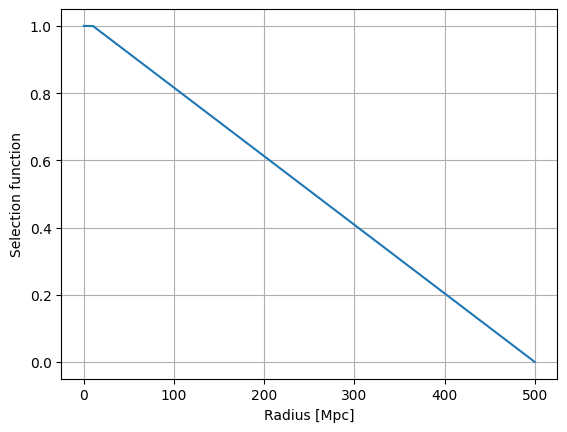

In [41]:
def func(x):
    func = np.zeros_like(x)
    range = (10 <= x) & (x <= 500)
    func[range] = (-1/490)*x[range] + 1 + (10/490)
    return func

radius = np.arange(0,500,0.01)
selection_function = np.ones_like(radius)
selection_function[radius > 10] = func(radius[radius > 10])

plt.plot(radius,selection_function)
# plt.hlines(0,0,500,colors='black')
# plt.semilogx()
plt.grid()
plt.xlabel('Radius [Mpc]')
plt.ylabel('Selection function')
plt.show()

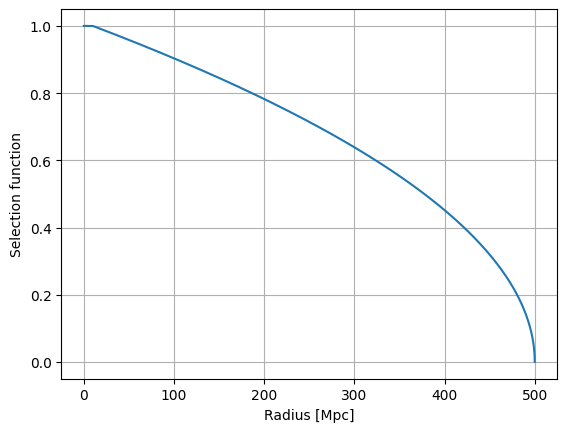

In [34]:
def func2(x, alpha = 0.5):
    return np.power((500 - x)/490, alpha)

radius = np.linspace(0,500,1+2**12)
selection_function = np.ones_like(radius)
selection_function[radius > 10] = func2(radius[radius > 10])

plt.plot(radius,selection_function)
# plt.hlines(0,0,500,colors='black')
# plt.semilogx()
plt.grid()
plt.xlabel('Radius [Mpc]')
plt.ylabel('Selection function')
plt.show()

In [55]:
with h5py.File('/disks/cosmodm/vdvuurst/data/M12-15.5_0.5dex/velocity_data_M1_13.0-13.5_M2_13.5-14.0.hdf5','r') as file:
    radius = file['radial_distances'][:]



In [ ]:
def func(x,a = 13.365): #value for a works to reduce the probability to ~1% with this equation, emprically found
    return ((-1/490)*x + 1 + (10/490)) / a

radius_cut = radius[radius <= 500]
print(radius_cut.shape[0] / radius.shape[0])
alpha = func(radius_cut)
num = (np.random.rand(radius_cut.shape[0]) < alpha).sum()
num / radius.shape[0]

0.5236270566253007


np.float64(0.009996752027994021)

In [4]:
mass_range = np.arange(2, 6, 0.5).astype(np.float32)
mass_bins = np.array([[mass_range[i],mass_range[i+1]] for i in range(len(mass_range)-1)])
bin_combis = np.array(list(combinations_with_replacement(mass_bins,2)))

bin_combis+10

array([[[12. , 12.5],
        [12. , 12.5]],

       [[12. , 12.5],
        [12.5, 13. ]],

       [[12. , 12.5],
        [13. , 13.5]],

       [[12. , 12.5],
        [13.5, 14. ]],

       [[12. , 12.5],
        [14. , 14.5]],

       [[12. , 12.5],
        [14.5, 15. ]],

       [[12. , 12.5],
        [15. , 15.5]],

       [[12.5, 13. ],
        [12.5, 13. ]],

       [[12.5, 13. ],
        [13. , 13.5]],

       [[12.5, 13. ],
        [13.5, 14. ]],

       [[12.5, 13. ],
        [14. , 14.5]],

       [[12.5, 13. ],
        [14.5, 15. ]],

       [[12.5, 13. ],
        [15. , 15.5]],

       [[13. , 13.5],
        [13. , 13.5]],

       [[13. , 13.5],
        [13.5, 14. ]],

       [[13. , 13.5],
        [14. , 14.5]],

       [[13. , 13.5],
        [14.5, 15. ]],

       [[13. , 13.5],
        [15. , 15.5]],

       [[13.5, 14. ],
        [13.5, 14. ]],

       [[13.5, 14. ],
        [14. , 14.5]],

       [[13.5, 14. ],
        [14.5, 15. ]],

       [[13.5, 14. ],
        [15.

In [2]:
PATH = "/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP-HBT/halo_properties_0077.hdf5"

with h5py.File(PATH, "r") as handle:
    COMvelocity = handle["ExclusiveSphere/100kpc/CentreOfMassVelocity"][:]
    HaloCatalogueIndex = handle["InputHalos/HaloCatalogueIndex"][:]
    SOMass = handle['SO/200_mean/TotalMass'][:] #TODO: verify that this is a good choice
    NoofBoundParticles = handle["InputHalos/NumberOfBoundParticles"][:]
    COM = handle["ExclusiveSphere/100kpc/CentreOfMass"][:]
    IsCentral = handle["InputHalos/IsCentral"][:].astype(bool) #set to bool so it can be used as a mask
    boxsize = handle['Header'].attrs['BoxSize'][0]


array([1146.       , 1180.       ,  663.       , ...,    9.8125   ,
          6.9140625,    8.       ], shape=(15329653,), dtype=float32)

In [8]:
from TWOHALO import _make_mass_mask

mask = _make_mass_mask(SOMass, 2,2.5)

mask.sum()

np.int64(1151840)

In [ ]:
test = np.zeros(10*2).reshape(10,2)
counter = 0
for i in range(5):
    # test[counter:counter+2] = [(1,2),(1,2)]
    test[counter:counter+2] = [(1,2),(1,2)]
    counter += 2

test

array([[1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.],
       [1., 2.]])

In [25]:
mass_range = np.arange(12,16,0.5)
bins = np.array([[mass_range[i],mass_range[i+1]] for i in range(len(mass_range)-1)])
combis = list(combinations_with_replacement(bins,2))
combis,len(combis)

([(array([12. , 12.5]), array([12. , 12.5])),
  (array([12. , 12.5]), array([12.5, 13. ])),
  (array([12. , 12.5]), array([13. , 13.5])),
  (array([12. , 12.5]), array([13.5, 14. ])),
  (array([12. , 12.5]), array([14. , 14.5])),
  (array([12. , 12.5]), array([14.5, 15. ])),
  (array([12. , 12.5]), array([15. , 15.5])),
  (array([12.5, 13. ]), array([12.5, 13. ])),
  (array([12.5, 13. ]), array([13. , 13.5])),
  (array([12.5, 13. ]), array([13.5, 14. ])),
  (array([12.5, 13. ]), array([14. , 14.5])),
  (array([12.5, 13. ]), array([14.5, 15. ])),
  (array([12.5, 13. ]), array([15. , 15.5])),
  (array([13. , 13.5]), array([13. , 13.5])),
  (array([13. , 13.5]), array([13.5, 14. ])),
  (array([13. , 13.5]), array([14. , 14.5])),
  (array([13. , 13.5]), array([14.5, 15. ])),
  (array([13. , 13.5]), array([15. , 15.5])),
  (array([13.5, 14. ]), array([13.5, 14. ])),
  (array([13.5, 14. ]), array([14. , 14.5])),
  (array([13.5, 14. ]), array([14.5, 15. ])),
  (array([13.5, 14. ]), array([15.

In [13]:
combis = np.array(list(combinations(mass_range,2)))
print(combis)

[[12.  12.5]
 [12.  13. ]
 [12.  13.5]
 [12.  14. ]
 [12.  14.5]
 [12.  15. ]
 [12.  15.5]
 [12.5 13. ]
 [12.5 13.5]
 [12.5 14. ]
 [12.5 14.5]
 [12.5 15. ]
 [12.5 15.5]
 [13.  13.5]
 [13.  14. ]
 [13.  14.5]
 [13.  15. ]
 [13.  15.5]
 [13.5 14. ]
 [13.5 14.5]
 [13.5 15. ]
 [13.5 15.5]
 [14.  14.5]
 [14.  15. ]
 [14.  15.5]
 [14.5 15. ]
 [14.5 15.5]
 [15.  15.5]]


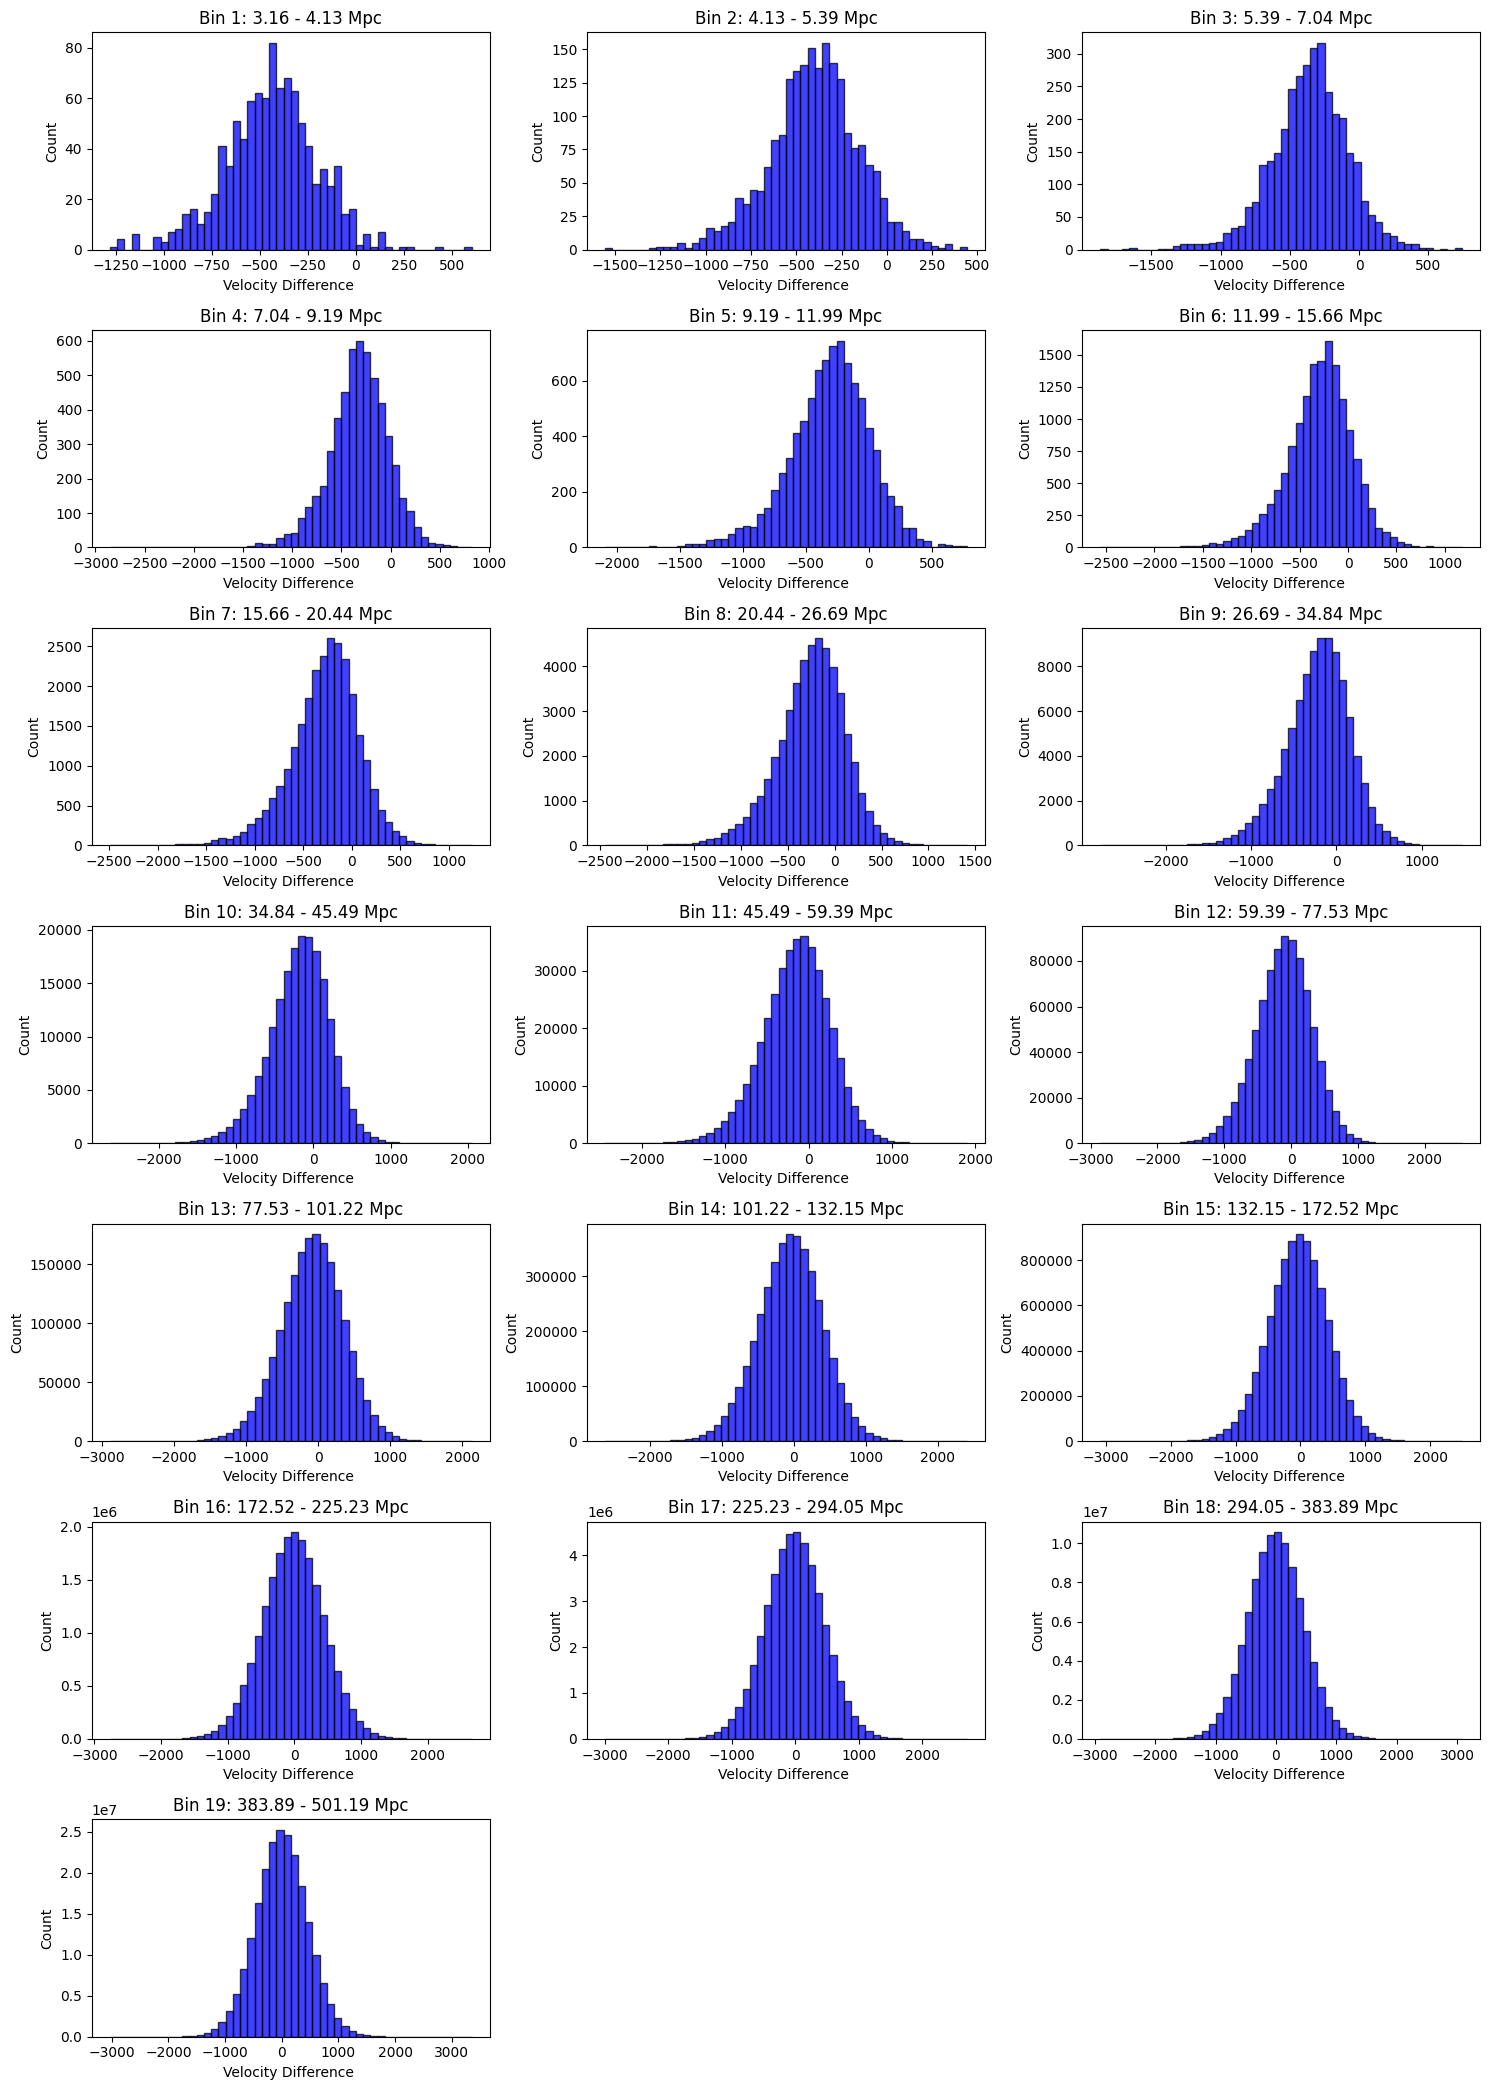

In [2]:
# Define radial bins
radial_bins = np.logspace(0.5, 2.7, 20).astype(np.float32)

with h5py.File("/disks/cosmodm/vdvuurst/data/velocity_data_M4_4_5.hdf5", "r") as f:
# with h5py.File("velocity_data_M14_14_5_trial_NORMAL_SIGMA_largersecondary_newquantity_lowsigma8.h5", "r") as f:
    radial_distances = f["radial_distances"][:]
    velocities = f["velocity_differences"][:]
    
# np.max(radial_distances)
bin_indices = np.digitize(radial_distances, bins=radial_bins) - 1
num_bins = len(radial_bins) - 1  


num_cols = 3
num_rows = int(np.ceil(num_bins / num_cols))  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  

mean, dispersion, skews, kurt = [], [], [], []

for bin_idx in range(num_bins):
    bin_mask = bin_indices == bin_idx
    bin_velocities = velocities[bin_mask]
    
    if len(bin_velocities) == 0:
        continue

    mean.append(np.mean(bin_velocities))
    dispersion.append(np.std(bin_velocities))
    skews.append(skew(bin_velocities))
    kurt.append(kurtosis(bin_velocities))
    
    ax = axes[bin_idx]
    ax.hist(bin_velocities, bins=50, alpha=0.75, color='b', edgecolor='black')
    ax.set_xlabel("Velocity Difference ")
    ax.set_ylabel("Count")
    ax.set_title(f"Bin {bin_idx + 1}: {radial_bins[bin_idx]:.2f} - {radial_bins[bin_idx + 1]:.2f} Mpc")


for i in range(num_bins, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig("velocity_histograms_new2halo.png", dpi=700)
plt.show()


In [3]:
radial_distances.shape[0]

767657375

## Plot of the moments of the distributions

In [4]:
# radial_bins = np.logspace(0.5, 2.7, 20).astype(np.float32)
radial_bins = np.linspace(np.min(radial_distances),np.max(radial_distances),30).astype(np.float32)
# np.max(radial_distances)
bin_indices = np.digitize(radial_distances, bins=radial_bins) - 1
num_bins = len(radial_bins) - 1  

mean, dispersion, skews, kurt = [], [], [], []

for bin_idx in range(num_bins):
    bin_mask = bin_indices == bin_idx
    bin_velocities = velocities[bin_mask]
    
    if len(bin_velocities) == 0:
        continue

    mean.append(np.mean(bin_velocities))
    dispersion.append(np.std(bin_velocities))
    skews.append(skew(bin_velocities))
    kurt.append(kurtosis(bin_velocities,fisher = False))


In [5]:
# We define some properties for the figures
SMALL_SIZE = 10 * 2 
MEDIUM_SIZE = 12 * 2
BIGGER_SIZE = 14 * 2

plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize\n",
mpl.rcParams['axes.titlesize'] = BIGGER_SIZE
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXgeneral'

mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.minor.size'] = 4

mpl.rcParams['xtick.major.width'] = 1.25
mpl.rcParams['ytick.major.width'] = 1.25
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1

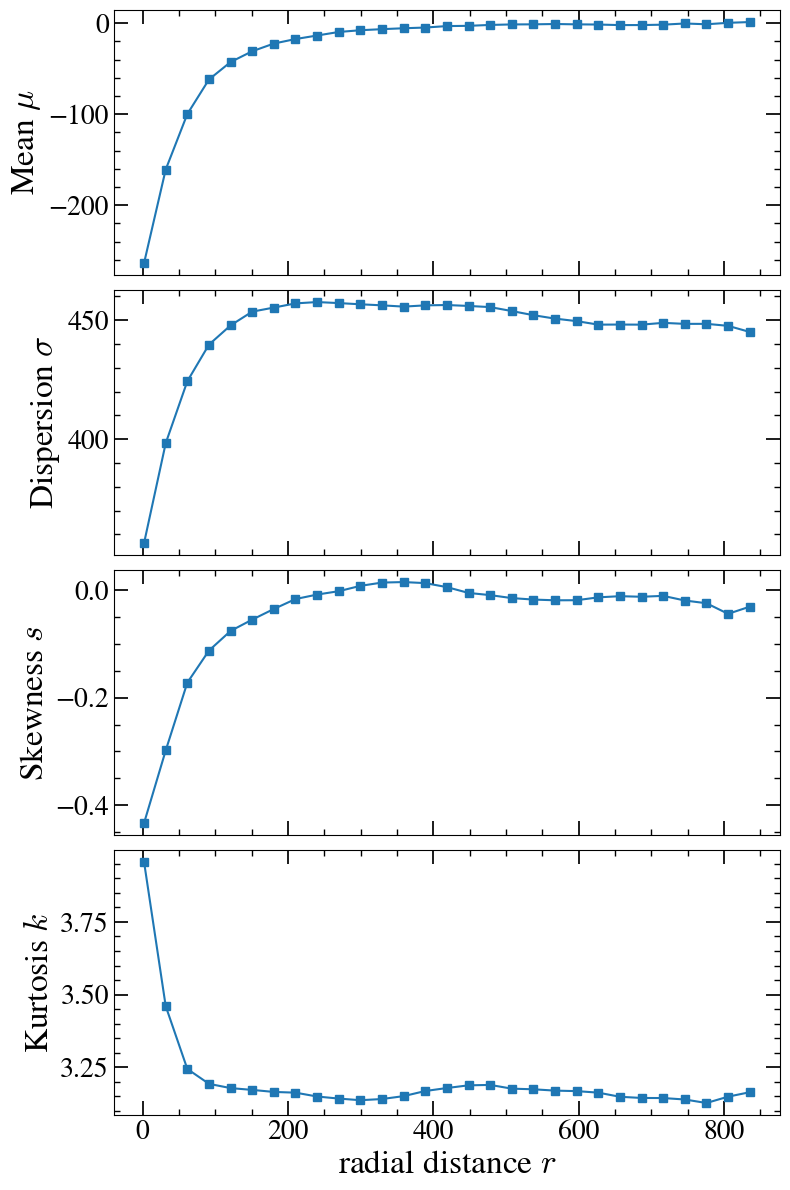

In [6]:
fig,axes = plt.subplots(nrows = 4,figsize=(8,12), sharex=True, layout='tight')

axes[0].plot(radial_bins[:-1],mean,marker='s')
axes[0].set(ylabel = r'Mean $\mu$')
axes[1].plot(radial_bins[:-1],dispersion, marker = 's')
axes[1].set(ylabel = r'Dispersion $\sigma$')
axes[2].plot(radial_bins[:-1], skews, marker = 's')
axes[2].set(ylabel = r'Skewness $s$')
axes[3].plot(radial_bins[:-1], kurt, marker='s')
axes[3].set(xlabel = r'radial distance $r$', ylabel = r'Kurtosis $k$')

plt.subplots_adjust(wspace = 0, hspace=0)

plt.show()